# Iteration 2 - TableNet Model

> **Dataset**: Client Dataset <br/>
> **Model**: TableNet Model <br/>
> **Creator**: Ryo & Naomi

### Import Libraries

In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Global Variables

In [2]:
# Global Variables
IMAGE_FOLDER = "../data/data-understanding/2. Non Duplicated"  # Folder containing images
XML_FOLDER = "../data/xml"         # Folder containing XML files
PREFIX = "clahe_gaussian_"                        # Prefix for image filenames

# Directories for saving masks
MASKING_BASE_FOLDER = "../data/masking"  # Base folder for saving masks

# Target size for images and masks
TARGET_SIZE = (0, 0)           # Size to resize images and masks
EPOCHS = 2

# Annotation types to extract from XML files (can add more in the future)
ANNOTATION_TYPES = ["row", "colum", "table", "year", "location"]  # Specify object names to extract

In [3]:
def get_matching_pairs(image_folder, xml_folder, prefix):
    image_files = {f[len(prefix):].split('.')[0]: os.path.join(image_folder, f)
                   for f in os.listdir(image_folder) if f.startswith(prefix)}
    xml_files = {f.split('.')[0]: os.path.join(xml_folder, f)
                 for f in os.listdir(xml_folder) if f.endswith('.xml')}
    paired_files = [(image_files[key], xml_files[key]) for key in xml_files if key in image_files]
    
    print("Loaded Pairs:")
    for image_path, xml_path in paired_files:
        print(f"- Image: {os.path.basename(image_path)}, XML: {os.path.basename(xml_path)}")
    print(f"\nTotal Files Loaded: {len(paired_files)}")
    
    return paired_files

In [4]:
paired_files = get_matching_pairs(IMAGE_FOLDER, XML_FOLDER, PREFIX)

Loaded Pairs:
- Image: clahe_gaussian_DSC00916.JPG, XML: DSC00916.xml
- Image: clahe_gaussian_DSC00917.JPG, XML: DSC00917.xml
- Image: clahe_gaussian_DSC00918.JPG, XML: DSC00918.xml
- Image: clahe_gaussian_DSC00919.JPG, XML: DSC00919.xml
- Image: clahe_gaussian_DSC00920.JPG, XML: DSC00920.xml
- Image: clahe_gaussian_DSC00921.JPG, XML: DSC00921.xml
- Image: clahe_gaussian_DSC00922.JPG, XML: DSC00922.xml
- Image: clahe_gaussian_DSC00923.JPG, XML: DSC00923.xml
- Image: clahe_gaussian_DSC00925.JPG, XML: DSC00925.xml
- Image: clahe_gaussian_DSC00929.JPG, XML: DSC00929.xml
- Image: clahe_gaussian_DSC00930.JPG, XML: DSC00930.xml
- Image: clahe_gaussian_DSC00931.JPG, XML: DSC00931.xml
- Image: clahe_gaussian_DSC00932.JPG, XML: DSC00932.xml
- Image: clahe_gaussian_DSC00933.JPG, XML: DSC00933.xml
- Image: clahe_gaussian_DSC00934.JPG, XML: DSC00934.xml
- Image: clahe_gaussian_DSC00935.JPG, XML: DSC00935.xml
- Image: clahe_gaussian_DSC00936.JPG, XML: DSC00936.xml
- Image: clahe_gaussian_DSC00937.J

In [5]:
def create_mask_directories():
    base_path = MASKING_BASE_FOLDER  # Use the global variable MASKING_BASE_FOLDER
    mask_dirs = {annotation_type: os.path.join(base_path, annotation_type) for annotation_type in ANNOTATION_TYPES}
    
    for path in mask_dirs.values():
        os.makedirs(path, exist_ok=True)  # Create the directory if it doesn't exist
    
    return mask_dirs

In [6]:
mask_directories = create_mask_directories()
print("Mask directories created:", mask_directories)

Mask directories created: {'row': '../data/masking\\row', 'colum': '../data/masking\\colum', 'table': '../data/masking\\table', 'year': '../data/masking\\year', 'location': '../data/masking\\location'}


In [7]:
def load_image(image_path):
    image = cv2.imread(image_path)
    return image

In [8]:
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotations = {key: [] for key in ANNOTATION_TYPES}
    
    for elem in root.findall(".//object"):
        obj_name = elem.find("name").text.lower()
        bndbox = elem.find("bndbox")
        
        if bndbox is not None and obj_name in annotations:
            xmin = int(float(bndbox.find("xmin").text))
            ymin = int(float(bndbox.find("ymin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymax = int(float(bndbox.find("ymax").text))
            annotations[obj_name].append([xmin, ymin, xmax, ymax])
    
    return annotations

In [9]:
def create_outline_mask(annotation, image_size, annotation_types):
    mask = np.zeros((*image_size[:2], len(annotation_types)), dtype=np.uint8)
    
    for i, key in enumerate(annotation_types):
        for box in annotation[key]:
            xmin, ymin, xmax, ymax = box
            if xmin < xmax and ymin < ymax:  # Ensure valid bounding box coordinates
                # Draw rectangle outline instead of filling the area
                mask_layer = mask[:, :, i].copy()
                cv2.rectangle(mask_layer, (xmin, ymin), (xmax, ymax), color=1, thickness=2)  # Ensure correct arguments
                mask[:, :, i] = mask_layer
    
    return mask

In [10]:
images = []
masks = []
mask_paths = {annotation_type: [] for annotation_type in ANNOTATION_TYPES}

for image_path, xml_path in paired_files:
    image = load_image(image_path)
    if image is None:
        continue
    original_size = (image.shape[1], image.shape[0])
    annotation = parse_xml(xml_path)
    mask = create_outline_mask(annotation, image.shape, ANNOTATION_TYPES)
    masks.append(mask)
    images.append(image)
    
    # Export masking images to corresponding folders and store paths in table
    for i, annotation_type in enumerate(ANNOTATION_TYPES):
        mask_filename = os.path.basename(image_path).replace(PREFIX, '').replace('.jpg', f'_{annotation_type}_mask.jpg')
        mask_path = os.path.join(mask_directories[annotation_type], mask_filename)
        cv2.imwrite(mask_path, mask[:, :, i] * 255)
        mask_paths[annotation_type].append(mask_path)

In [ ]:
# def visualize_images_and_masks(images, masks, annotation_types, sample_size=5):
#     """
#     Visualize a set of images and their corresponding masks.

#     Parameters:
#     - images (list): List of images (numpy arrays).
#     - masks (list): List of masks (numpy arrays with shape [H, W, annotation_types]).
#     - annotation_types (list): List of annotation types.
#     - sample_size (int): Number of samples to visualize.

#     Returns:
#     - None
#     """
#     num_samples = min(sample_size, len(images))
#     num_columns = len(annotation_types) + 1  # One column for the image + one per mask

#     # Create a single figure for all samples
#     fig, axes = plt.subplots(num_samples, num_columns, figsize=(15, 5 * num_samples))
#     axes = np.atleast_2d(axes)  # Ensure we have a 2D array even if num_samples=1

#     for i in range(num_samples):
#         # Original Image
#         axes[i, 0].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
#         axes[i, 0].set_title('Original Image')
#         axes[i, 0].axis('off')

#         # Masks for each annotation type
#         for j, annotation_type in enumerate(annotation_types):
#             axes[i, j + 1].imshow(masks[i][:, :, j], cmap='gray')
#             axes[i, j + 1].set_title(f'{annotation_type} Mask')
#             axes[i, j + 1].axis('off')

#     plt.tight_layout()
#     plt.show()

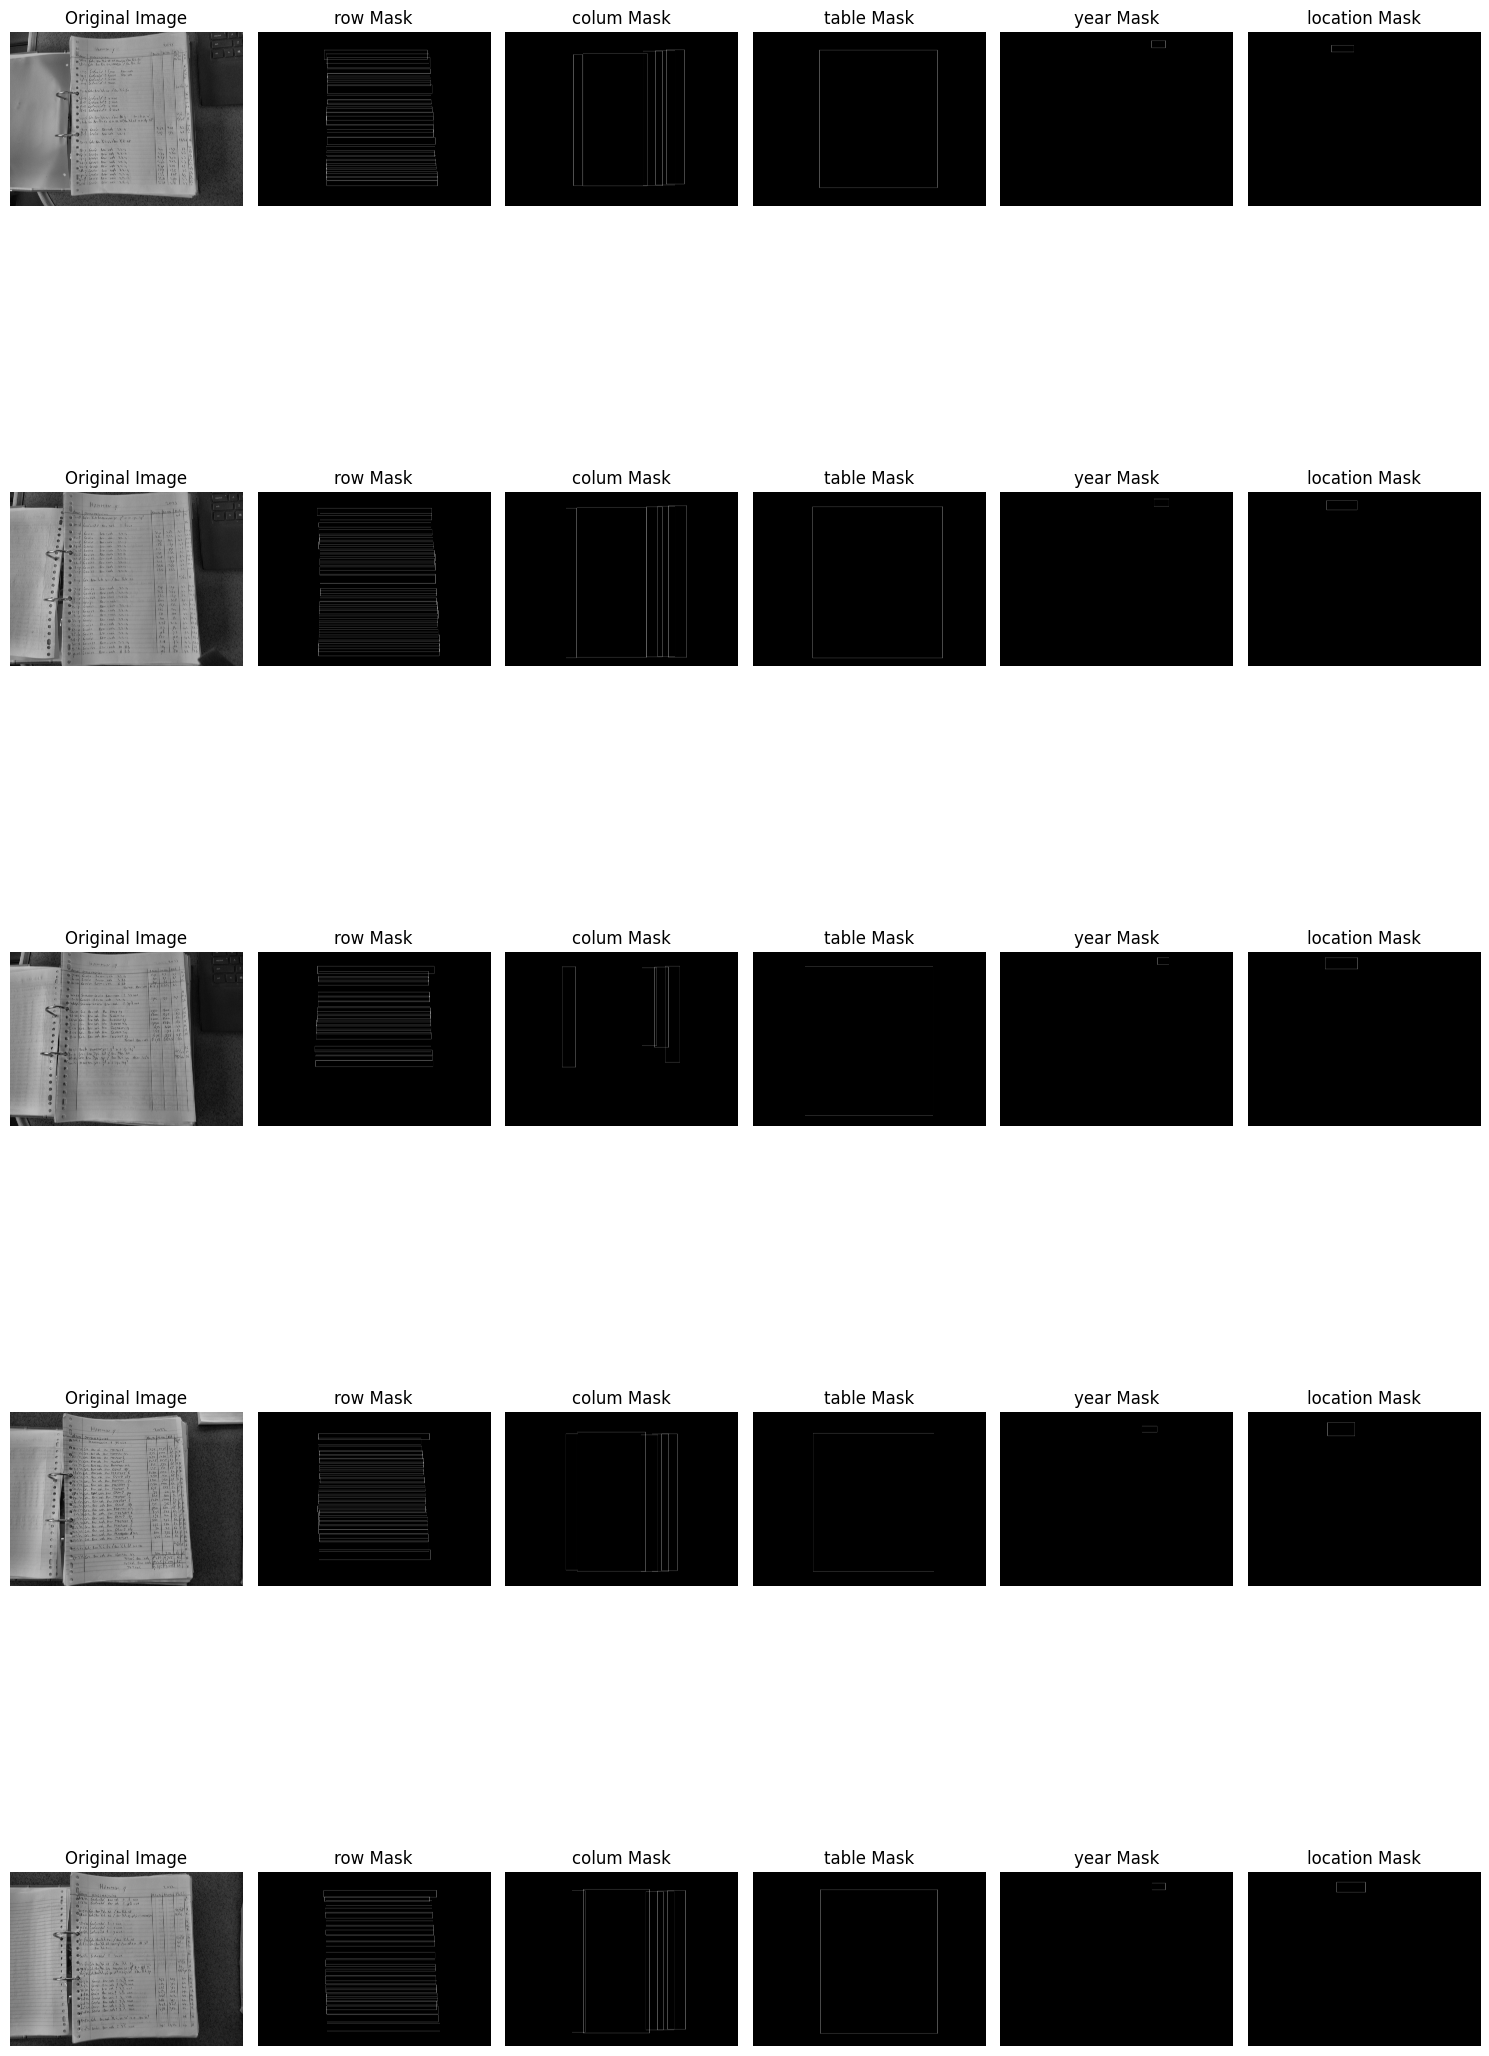

In [ ]:
# visualize_images_and_masks(images, masks, ANNOTATION_TYPES, sample_size=5)

In [13]:
def create_complete_file_table(image_paths, mask_paths):
    data = {"image_path": image_paths}
    for annotation_type in ANNOTATION_TYPES:
        data[f'{annotation_type}_mask_path'] = mask_paths[annotation_type]
    return pd.DataFrame(data)

In [14]:
file_table = create_complete_file_table([pair[0] for pair in paired_files], mask_paths)
file_table.head()

,image_path,row_mask_path,colum_mask_path,table_mask_path,year_mask_path,location_mask_path
0,../data/data-understanding/2. Non Duplicated\c...,../data/masking\row\DSC00916.JPG,../data/masking\colum\DSC00916.JPG,../data/masking\table\DSC00916.JPG,../data/masking\year\DSC00916.JPG,../data/masking\location\DSC00916.JPG
1,../data/data-understanding/2. Non Duplicated\c...,../data/masking\row\DSC00917.JPG,../data/masking\colum\DSC00917.JPG,../data/masking\table\DSC00917.JPG,../data/masking\year\DSC00917.JPG,../data/masking\location\DSC00917.JPG
2,../data/data-understanding/2. Non Duplicated\c...,../data/masking\row\DSC00918.JPG,../data/masking\colum\DSC00918.JPG,../data/masking\table\DSC00918.JPG,../data/masking\year\DSC00918.JPG,../data/masking\location\DSC00918.JPG
3,../data/data-understanding/2. Non Duplicated\c...,../data/masking\row\DSC00919.JPG,../data/masking\colum\DSC00919.JPG,../data/masking\table\DSC00919.JPG,../data/masking\year\DSC00919.JPG,../data/masking\location\DSC00919.JPG
4,../data/data-understanding/2. Non Duplicated\c...,../data/masking\row\DSC00920.JPG,../data/masking\colum\DSC00920.JPG,../data/masking\table\DSC00920.JPG,../data/masking\year\DSC00920.JPG,../data/masking\location\DSC00920.JPG


In [15]:
train_df, test_df = train_test_split(file_table, test_size=0.2, random_state=42)  # 20% for test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 25% of remaining 80% for validation (total 20% validation)

print("Training set size (60%):", len(train_df))
print("Validation set size (20%):", len(val_df))
print("Test set size (20%):", len(test_df))

Training set size (60%): 11
Validation set size (20%): 4
Test set size (20%): 4


In [17]:
def data_generator(df, batch_size, target_size):
    while True:
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            masks = {annotation_type: [] for annotation_type in ANNOTATION_TYPES}

            for _, row in batch_df.iterrows():
                image = cv2.imread(row['image_path'])
                image = cv2.resize(image, target_size) if target_size != (0, 0) else image
                image = image / 255.0
                images.append(image)

                for annotation_type in ANNOTATION_TYPES:
                    mask_image = cv2.imread(row[f'{annotation_type}_mask_path'], cv2.IMREAD_GRAYSCALE)
                    mask_image = cv2.resize(mask_image, target_size) if target_size != (0, 0) else mask_image
                    masks[annotation_type].append(mask_image / 255.0)

            images = np.array(images, dtype=np.float32)
            masks = [np.expand_dims(np.array(masks[annotation_type], dtype=np.float32), axis=-1) for annotation_type in ANNOTATION_TYPES]

            yield images, tuple(masks)

In [18]:
def create_tf_dataset(df, batch_size, target_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(df, batch_size, target_size),
        output_signature=(
            tf.TensorSpec(shape=(batch_size, target_size[0], target_size[1], 3), dtype=tf.float32),
            (
                tf.TensorSpec(shape=(batch_size, target_size[0], target_size[1], 1), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, target_size[0], target_size[1], 1), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, target_size[0], target_size[1], 1), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, target_size[0], target_size[1], 1), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, target_size[0], target_size[1], 1), dtype=tf.float32),
            ),
        ),
    )
    
    # Apply augmentations if needed
    def augment(image, masks):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        return image, masks

    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [19]:
# Define batch size and target size for the dataset
BATCH_SIZE = 8
TARGET_SIZE = (256, 256) if TARGET_SIZE == (0, 0) else TARGET_SIZE

# Creating training, validation, and test datasets
train_dataset = create_tf_dataset(train_df, BATCH_SIZE, TARGET_SIZE)
val_dataset = create_tf_dataset(val_df, BATCH_SIZE, TARGET_SIZE)
test_dataset = create_tf_dataset(test_df, BATCH_SIZE, TARGET_SIZE)

In [28]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None)))>

In [20]:
def TableNet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # VGG19 as encoder
    vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)

    # Freeze the encoder layers
    for layer in vgg19.layers:
        layer.trainable = False

    # Extract features from different layers of VGG19
    skip_connections = [
        vgg19.get_layer("block1_conv2").output,
        vgg19.get_layer("block2_conv2").output,
        vgg19.get_layer("block3_conv4").output,
        vgg19.get_layer("block4_conv4").output
    ]
    bottleneck = vgg19.get_layer("block5_conv4").output

    def decoder_block(x, skip_features, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip_features])
        x = layers.SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.2)(x)
        return x

    def build_output_decoder(name, bottleneck, skip_connections):
        x = bottleneck
        filters = [256, 128, 64, 32]
        for i, skip in enumerate(skip_connections[::-1]):
            x = decoder_block(x, skip, filters[i])
        output = layers.Conv2D(1, (1, 1), activation='sigmoid', name=name)(x)
        return output

    # Define outputs
    outputs = [
        build_output_decoder("table_output", bottleneck, skip_connections),
        build_output_decoder("column_output", bottleneck, skip_connections),
        build_output_decoder("row_output", bottleneck, skip_connections),
        build_output_decoder("year_output", bottleneck, skip_connections),
        build_output_decoder("location_output", bottleneck, skip_connections)
    ]

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
# Create TableNet model
input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
model = TableNet(input_shape=input_shape)

d:\Software\Python\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [22]:
# model.summary()

In [23]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'table_output': 'binary_crossentropy',
        'column_output': 'binary_crossentropy',
        'row_output': 'binary_crossentropy',
        'year_output': 'binary_crossentropy',
        'location_output': 'binary_crossentropy'
    },
    metrics={
        'table_output': 'accuracy',
        'column_output': 'accuracy',
        'row_output': 'accuracy',
        'year_output': 'accuracy',
        'location_output': 'accuracy'
    }
)

In [24]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#     ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss'),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# ]

In [29]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    # callbacks=callbacks,
    verbose=1
)

Epoch 1/2
      1/Unknown 132s 132s/step - column_output_accuracy: 0.4509 - column_output_loss: 0.8215 - location_output_accuracy: 0.8322 - location_output_loss: 0.5176 - loss: 3.6329 - row_output_accuracy: 0.5981 - row_output_loss: 0.6775 - table_output_accuracy: 0.7079 - table_output_loss: 0.6126 - year_output_accuracy: 0.2994 - year_output_loss: 1.0039

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element of shape (3, 256, 256, 3) where an element of shape (8, 256, 256, 3) was expected.
Traceback (most recent call last):

  File "d:\Software\Python\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "d:\Software\Python\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "d:\Software\Python\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (3, 256, 256, 3) where an element of shape (8, 256, 256, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_50516]

In [26]:
model.save('final_tablenet_model.h5')